# Question 3

In [4]:
import cvxopt
import numpy as np
import time
import matplotlib.pyplot as plt

### Q3 Part a

In [2]:
# Toy data from class
X = np.array([[0, 0], [2, 2], [2, 0], [3, 0]])
y = np.array([-1, -1, 1, 1])

In [3]:
n = X.shape[0]
d = X.shape[1]

# Create the Q matrix
Q = np.eye(d+1)
Q[0, 0] = 0
print("Q = \n", Q)

# Create the p vector
p = np.zeros(d+1)
print("p = \n", p)

# Create the A matrix
A = np.zeros((n, d+1))
A[:, 0] = y
A[:, 1:] = y[:, np.newaxis] * X
print("A = \n", A)

# Create the c vector
c = np.ones(n)
print("c = \n", c)

Q = 
 [[0. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
p = 
 [0. 0. 0.]
A = 
 [[-1.  0.  0.]
 [-1. -2. -2.]
 [ 1.  2.  0.]
 [ 1.  3.  0.]]
c = 
 [1. 1. 1. 1.]


In [4]:
# Solve the QP
sol = cvxopt.solvers.qp(cvxopt.matrix(Q), cvxopt.matrix(p.T), cvxopt.matrix(-A), cvxopt.matrix(-c.T)) #Need to make A and c negative to adjust to cvxopt format
print("sol = \n", sol['x'])

     pcost       dcost       gap    pres   dres
 0:  3.2653e-01  1.9592e+00  6e+00  2e+00  4e+00
 1:  1.5796e+00  8.5663e-01  7e-01  3e-16  3e-15
 2:  1.0195e+00  9.9227e-01  3e-02  5e-16  3e-15
 3:  1.0002e+00  9.9992e-01  3e-04  3e-16  2e-15
 4:  1.0000e+00  1.0000e+00  3e-06  3e-16  1e-15
 5:  1.0000e+00  1.0000e+00  3e-08  0e+00  3e-15
Optimal solution found.
sol = 
 [-1.00e+00]
[ 1.00e+00]
[-1.00e+00]



This solution matches what we found with the toy dataset in class

<br>

### Q3 Part b

In [6]:
import os
import contextlib
def time_cvxopt(n, d):
    # Make random data
    X = np.random.randn(n, d)
    y = np.random.choice([-1, 1], n)

    # Create the Q matrix
    Q = np.eye(d+1)
    Q[0, 0] = 0

    # Create the p vector
    p = np.zeros(d+1)

    # Create the A matrix
    A = np.zeros((n, d+1))

    A[:, 0] = y
    A[:, 1:] = y[:, np.newaxis] * X

    # Create the c vector
    c = np.ones(n)

    # Solve the QP
    start_time = time.time()
    with open(os.devnull, 'w') as fnull: # Pulled from oode used in another class to suppress output
        with contextlib.redirect_stdout(fnull):
            sol = cvxopt.solvers.qp(cvxopt.matrix(Q), cvxopt.matrix(p.T), cvxopt.matrix(-A), cvxopt.matrix(-c.T)) #Need to make A and c negative to adjust to cvxopt format
    end_time = time.time()
    return end_time - start_time

d_time = []
for d in np.arange(100, 2500, 50):
    if d % 500 == 0: # Check to see progress
        print("d = ", d)
    d_time.append(time_cvxopt(100, d))

n_time = []
for n in np.arange(100, 2500, 50):
    if n % 500 == 0: # Check to see progress    
        print("n = ", n)
    n_time.append(time_cvxopt(n, 1000))

n =  500
n =  1000
n =  1500
n =  2000


Text(0.5, 1.0, 'Time vs. n (d = 1000)')

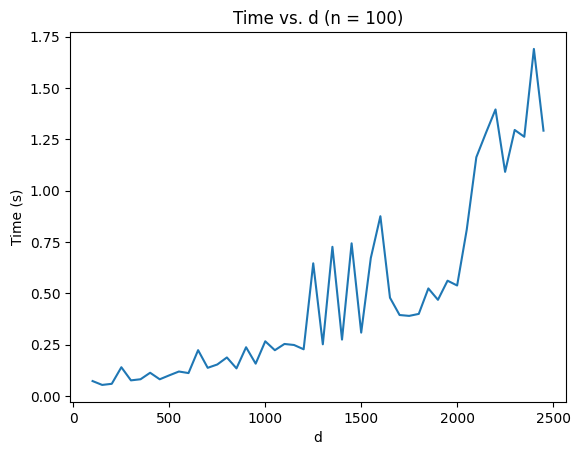

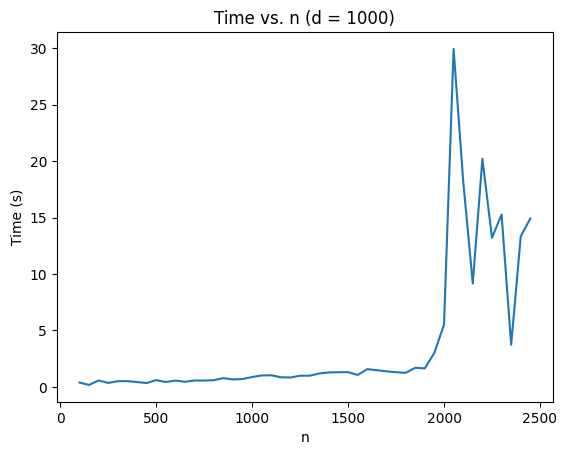

In [7]:
plt.figure()
plt.plot(np.arange(100, 2500, 50), d_time)
plt.xlabel("d")
plt.ylabel("Time (s)")
plt.title("Time vs. d (n = 100)")

plt.figure()
plt.plot(np.arange(100, 2500, 50), n_time)
plt.xlabel("n")
plt.ylabel("Time (s)")
plt.title("Time vs. n (d = 1000)")

Our algorithm is not guaranteed to be efficient given any size of X. As we go to higher numbers of features or datapoints we get an algorithm that grows more than linearly. The specfic big-oh notation is not obvious from the tests we have done above and would include more analysis into the calculation itself.

<br>

# Question 4

### Q4 Part a

In this part I add a point to the test data before that would be on the wrong side of the margin. Here I train both hard and soft margin SVM to see the difference. The results is that the hard margin changes a lot to make it still perfectly seperable while the soft margin keeps the same margin as before and just allows the point to be misclassified.

In [5]:
from sklearn.svm import SVC

# Define new toy data
X = np.array([[0, 0], [2, 2], [2, 0], [3, 0], [1, 0.5]])
y = np.array([-1, -1, 1, 1, 1])

svmHard = SVC(kernel='linear', C=1e9) # C is high to make it hard margin
svmHard.fit(X, y)

svmSoft = SVC(kernel='linear', C=1) # C is low to make it soft margin
svmSoft.fit(X, y)

print("SVM Hard Margin Coefficients = ", svmHard.coef_)
print("SVM Hard Margin Intercept = ", svmHard.intercept_)

print("SVM Soft Margin Coefficients = ", svmSoft.coef_)
print("SVM Soft Margin Intercept = ", svmSoft.intercept_)

SVM Hard Margin Coefficients =  [[ 3.9987253 -3.9991502]]
SVM Hard Margin Intercept =  [-0.99943347]
SVM Soft Margin Coefficients =  [[ 1. -1.]]
SVM Soft Margin Intercept =  [-1.]


In [6]:
# Code from Geron's textbook "Hands-On Machine Learning with Scikit-Learn and TensorFlow"
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0] / w[1] * x0 - b / w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin
    svs = svm_clf.support_vectors_

    plt.plot(x0, decision_boundary, "k-", linewidth=2, zorder=-2)
    plt.plot(x0, gutter_up, "k--", linewidth=2, zorder=-2)
    plt.plot(x0, gutter_down, "k--", linewidth=2, zorder=-2)
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#AAA',
                zorder=-1)

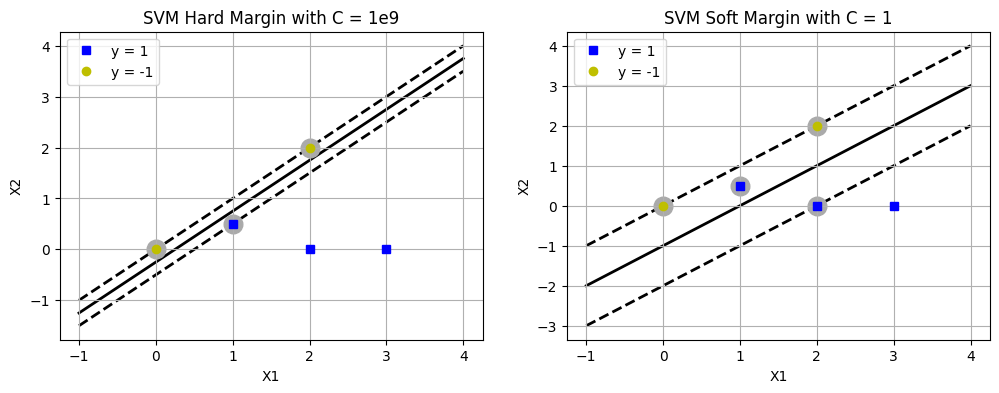

In [7]:
# Plot the decision boundaries for the SVMs
plt.figure(figsize=(12, 4))
plt.subplot(121)
plot_svc_decision_boundary(svmHard, -1, 4)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="y = 1")
plt.plot(X[:, 0][y==-1], X[:, 1][y==-1], "yo", label="y = -1")
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("SVM Hard Margin with C = 1e9")
plt.legend()
plt.grid()

plt.subplot(122)
plot_svc_decision_boundary(svmSoft, -1, 4)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="y = 1")
plt.plot(X[:, 0][y==-1], X[:, 1][y==-1], "yo", label="y = -1")
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("SVM Soft Margin with C = 1")
plt.legend()
plt.grid()


<br>

### Q4 Part b

In [8]:
import scipy.io as sio
from sklearn.model_selection import train_test_split
# Load data from data.mat
data = sio.loadmat('data.mat')
X = data['A']
y = data['L'].flatten()

print("X shape = ", X.shape)
print("y shape = ", y.shape)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=150, random_state=404)

print("X_train shape = ", X_train.shape)
print("y_train shape = ", y_train.shape)
print("X_test shape = ", X_test.shape)
print("y_test shape = ", y_test.shape)

X shape =  (3000, 256)
y shape =  (3000,)
X_train shape =  (150, 256)
y_train shape =  (150,)
X_test shape =  (2850, 256)
y_test shape =  (2850,)


In [9]:
# Fit the SVM for various values of C
C = np.logspace(-6, 6, 1000)
support_vectors = [] # Store the number of support vectors for each C
for c in C:
    svm = SVC(kernel='linear', C=c)
    svm.fit(X_train, y_train)
    support_vectors.append(svm.support_vectors_.shape[0])

Text(0.5, 1.0, 'Number of Support Vectors vs. C')

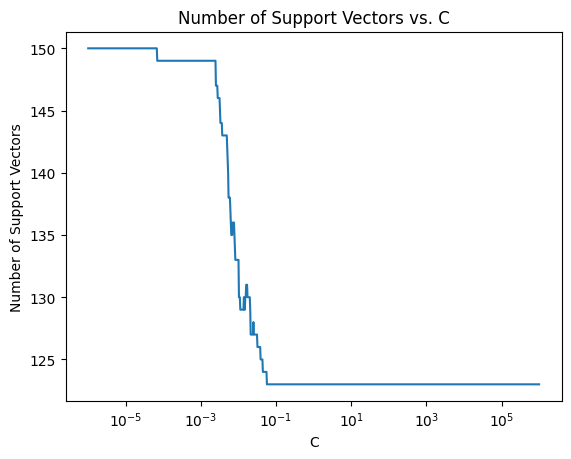

In [10]:
plt.plot(C, support_vectors)
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Number of Support Vectors')
plt.title('Number of Support Vectors vs. C')

In [11]:
# Looking at different kernels and C values

# Linear kernel
svm = SVC(kernel='linear', C=1)
svm.fit(X_train, y_train)
print("Linear kernel, C = 1, Training Accuracy = ", svm.score(X_train, y_train))
print("Linear kernel, C = 1, Testing Accuracy = ", svm.score(X_test, y_test))

svm = SVC(kernel='linear', C=1e-6)
svm.fit(X_train, y_train)
print("Linear kernel, C = 1e-6, Training Accuracy = ", svm.score(X_train, y_train))
print("Linear kernel, C = 1e-6, Testing Accuracy = ", svm.score(X_test, y_test))

svm = SVC(kernel='linear', C=1e6)
svm.fit(X_train, y_train)
print("Linear kernel, C = 1e6, Training Accuracy = ", svm.score(X_train, y_train))
print("Linear kernel, C = 1e6, Testing Accuracy = ", svm.score(X_test, y_test))

# Polynomial kernel
svm = SVC(kernel='poly', C=1)
svm.fit(X_train, y_train)
print("Polynomial kernel, C = 1, Training Accuracy = ", svm.score(X_train, y_train))
print("Polynomial kernel, C = 1, Testing Accuracy = ", svm.score(X_test, y_test))

svm = SVC(kernel='poly', C=1e-6)
svm.fit(X_train, y_train)
print("Polynomial kernel, C = 1e-6, Training Accuracy = ", svm.score(X_train, y_train))
print("Polynomial kernel, C = 1e-6, Testing Accuracy = ", svm.score(X_test, y_test))

svm = SVC(kernel='poly', C=1e6)
svm.fit(X_train, y_train)
print("Polynomial kernel, C = 1e6, Training Accuracy = ", svm.score(X_train, y_train))
print("Polynomial kernel, C = 1e6, Testing Accuracy = ", svm.score(X_test, y_test))

# RBF kernel
svm = SVC(kernel='rbf', C=1)
svm.fit(X_train, y_train)
print("RBF kernel, C = 1, Training Accuracy = ", svm.score(X_train, y_train))
print("RBF kernel, C = 1, Testing Accuracy = ", svm.score(X_test, y_test))

svm = SVC(kernel='rbf', C=1e-6)
svm.fit(X_train, y_train)
print("RBF kernel, C = 1e-6, Training Accuracy = ", svm.score(X_train, y_train))
print("RBF kernel, C = 1e-6, Testing Accuracy = ", svm.score(X_test, y_test))

svm = SVC(kernel='rbf', C=1e6)
svm.fit(X_train, y_train)
print("RBF kernel, C = 1e6, Training Accuracy = ", svm.score(X_train, y_train))
print("RBF kernel, C = 1e6, Testing Accuracy = ", svm.score(X_test, y_test))


Linear kernel, C = 1, Training Accuracy =  1.0
Linear kernel, C = 1, Testing Accuracy =  0.8698245614035087
Linear kernel, C = 1e-6, Training Accuracy =  0.16
Linear kernel, C = 1e-6, Testing Accuracy =  0.0968421052631579
Linear kernel, C = 1e6, Training Accuracy =  1.0
Linear kernel, C = 1e6, Testing Accuracy =  0.8698245614035087
Polynomial kernel, C = 1, Training Accuracy =  0.9866666666666667
Polynomial kernel, C = 1, Testing Accuracy =  0.8080701754385965
Polynomial kernel, C = 1e-6, Training Accuracy =  0.16
Polynomial kernel, C = 1e-6, Testing Accuracy =  0.0968421052631579
Polynomial kernel, C = 1e6, Training Accuracy =  1.0
Polynomial kernel, C = 1e6, Testing Accuracy =  0.8059649122807018
RBF kernel, C = 1, Training Accuracy =  0.9933333333333333
RBF kernel, C = 1, Testing Accuracy =  0.871578947368421
RBF kernel, C = 1e-6, Training Accuracy =  0.16
RBF kernel, C = 1e-6, Testing Accuracy =  0.0968421052631579
RBF kernel, C = 1e6, Training Accuracy =  1.0
RBF kernel, C = 1e6,